Tutorial: Task Dependency Management
====================================

Objective:

> Learning how ML workflows can be representated using acyclic task graphs, how to construct them and how they contribute to portability.

Principles:

1. Workflows are represented using dependencies of their tasks modeled by acyclic graphs.
2. The actual task graph can be displayed when selecting the `graphviz` runner.
3. Individual tasks are implemented using _Actors_ which can be _stateless_ or _stateful_.
4. _Train_ versus _Apply_ modes are represented using tightly coupled but distinct (in the case of stateful nodes) task graphs.
5. Operators are units of task graph topologies.
6. Operator composition is a non-linear operation combining two operators to produce more complex task graph topology.
7. Task graphs can be executed using different runners.

In [1]:
from datetime import datetime, date

from forml.project import Source
from forml.pipeline.payload import ToPandas

from tutorial import Dummy

Actors
------

### Stateless Mapping - Visualizing the Basic Dummy Pipeline

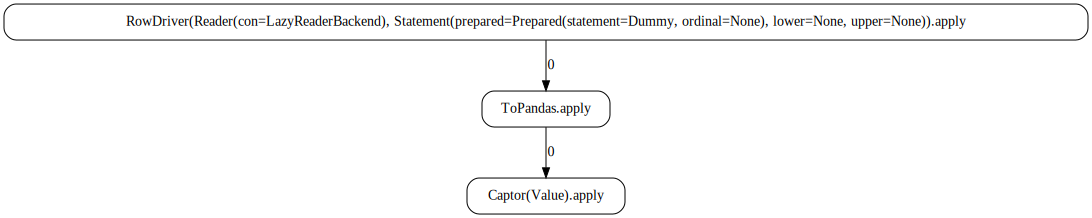

In [2]:
STATEMENT = Dummy

SOURCE = Source.query(STATEMENT)
PIPELINE = ToPandas()

SOURCE.bind(PIPELINE).launcher(runner='graphviz').apply()

### Implementing Stateless Actor using Decorators

### Implementing Stateful Actor

### Train versus Apply Mode Duality

Operators
---------

### Implementing Custom Operator

In [3]:
import typing

from imblearn import over_sampling

from forml import flow
from forml.pipeline import wrap


@wrap.Actor.apply
def OverSampler(features, labels, *, random_state: typing.Optional[int] = None):
    """Stateless actor  with two input and two output ports for oversampling the features/labels of the minor class."""
    return over_sampling.RandomOverSampler(random_state=random_state).fit_resample(
        features, labels
    )


class Balancer(flow.Operator):
    """Balancer operator inserting the provided sampler into the ``train`` & ``label`` paths."""

    def __init__(self, sampler: flow.Builder = OverSampler.builder(random_state=42)):
        self._sampler = sampler

    def compose(self, scope: flow.Composable) -> flow.Trunk:
        left = scope.expand()
        sampler = flow.Worker(self._sampler, 2, 2)
        sampler[0].subscribe(left.train.publisher)
        new_features = flow.Future()
        new_features[0].subscribe(sampler[0])
        sampler[1].subscribe(left.label.publisher)
        new_labels = flow.Future()
        new_labels[0].subscribe(sampler[1])
        return left.use(
            train=left.train.extend(tail=new_features),
            label=left.label.extend(tail=new_labels),
        )

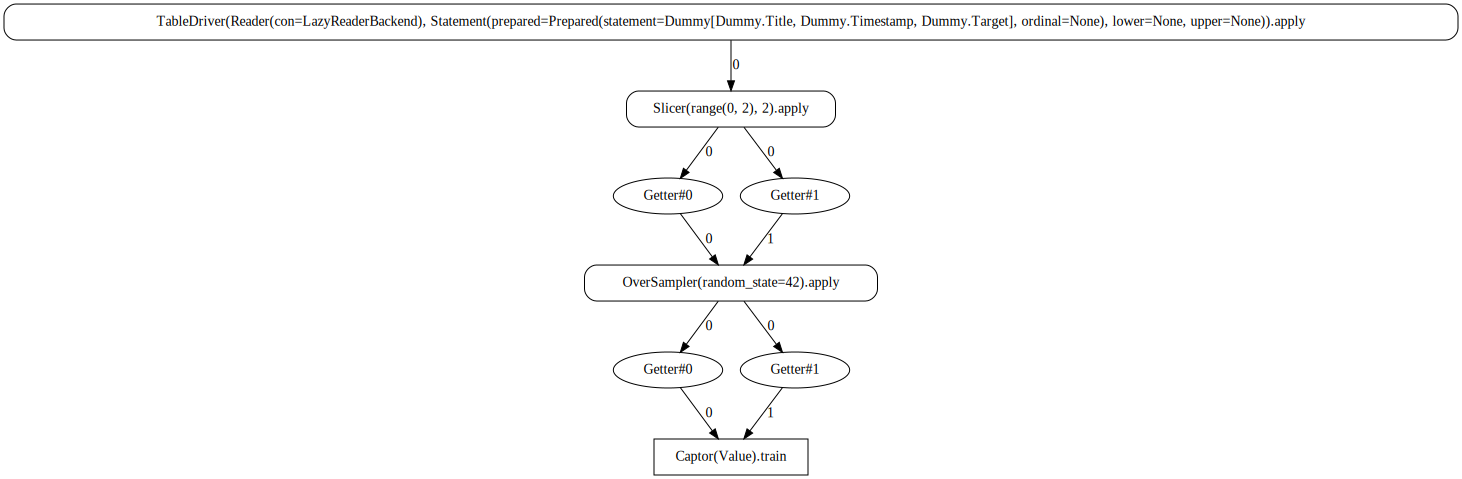

In [4]:
SOURCE = Source.query(Dummy.select(Dummy.Title, Dummy.Timestamp), labels=Dummy.Target)
PIPELINE = Balancer()

SOURCE.bind(PIPELINE).launcher(runner='graphviz').train()

### Operator Unit Testing

In [5]:
from forml import testing

class TestBalancer(testing.operator(Balancer)):
    """Balancer unit tests."""

    default_oversample = (
        testing.Case()
        .train([[1], [1], [0]], [1, 1, 0])
        .returns([[1], [1], [0], [0]], labels=[1, 1, 0, 0])
    )

In [6]:
import unittest
suite = unittest.TestSuite()
suite.addTest(TestBalancer('test_default_oversample'))

runner = unittest.TextTestRunner()
runner.run(suite)

.
----------------------------------------------------------------------
Ran 1 test in 2.035s

OK


<unittest.runner.TextTestResult run=1 errors=0 failures=0>

### Demonstrating Composition

### Auto-wrapping 3rd-party Components

Pipeline
--------

* Creating simple pipeline with an estimator
* Specifying Target Column
* Composition with an Estimator

Runners
-------

* Main Compute - Dask/Spark
* Alternative Runners - Graphviz, Pyfunc